## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-pack

1.14.0


C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a0923\Anaconda3\envs\kera

In [3]:
import os
# os.chdir(r'C:\Users\a0923\Desktop\python\cupoy\YOLO\keras-yolo3' ) 
os.chdir(r'C:\Users\a0923\Desktop\python\yolov3\keras-yolo3-master')
print (os.getcwd())

C:\Users\a0923\Desktop\python\yolov3\keras-yolo3-master


以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [4]:
if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

  # Pascal VOC 的資料類別
  classes = ["raccoon", "kangaroo"]
  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = "."

  for year, image_set in sets:
      image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids[:100]: # 只處理 100 張圖片來做範例
          list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()

In [5]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [6]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [7]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 10
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    history1 =model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
              steps_per_epoch=max(1, num_train//batch_size),
              validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
              validation_steps=max(1, num_val//batch_size),
              epochs=100,
              initial_epoch=0,
              callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 1 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history2 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=100,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')








Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\a0923\Anaconda3\envs\keras-yolo3\lib\site-packages\keras\

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 90 samples, val on 10 samples, with batch size 10.


Epoch 1/100
9/9 [==============================] - 13s 1s/step - loss: 4032.1548 - val_loss: 1823.9729
Epoch 2/100
9/9 [==============================] - 7s 729ms/step - loss: 1304.7236 - val_loss: 781.5185
Epoch 3/100
9/9 [==============================] - 7s 727ms/step - loss: 546.7354 - val_loss: 397.3814
Epoch 4/100
9/9 [==============================] - 7s 738ms/step - loss: 307.2435 - val_loss: 259.2647
Epoch 5/100
9/9 [==============================] - 7s 732ms/step - loss: 224.8273 - val_loss: 158.4673
Epoch 6/100
9/9 [==============================] - 7s 734ms/step - loss: 170.5463 - val_loss: 138.3786
Epoch 7/100
9/9 [==============================] - 7s 745ms/step - loss: 149.7187 - val_loss: 142.7334
Epoch 8/100
9/9 [==============

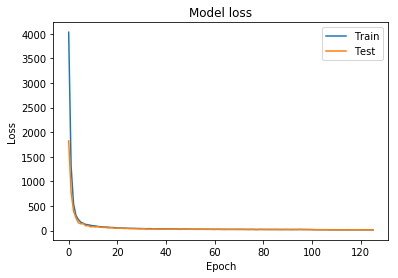

In [11]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'] + history2.history['loss'])
plt.plot(history1.history['val_loss'] + history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
from PIL import Image
image = Image.open('00002.jpg') 

In [16]:
from yolo import YOLO
log_dir = 'logs/000/'
classes_path = 'model_data/voc_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
# yolo_model = YOLO(model_path=log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_stage_1.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (145, 101) (474, 299)
1.7793175


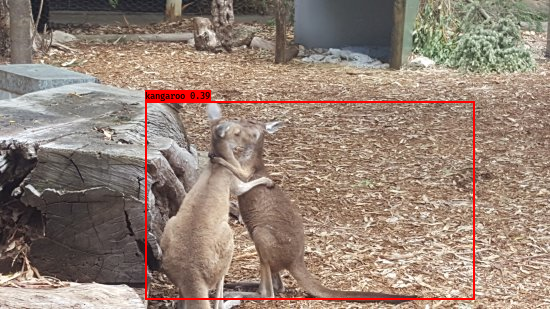

In [17]:
r_image